In [26]:
# Datatype counts per column
from collections import Counter
import pandas as pd

# Use existing DataFrame if available, otherwise try alternate name or re-read file
try:
    dataset = df
except NameError:
    try:
        dataset = data
    except NameError:
        dataset = pd.read_csv(r"C:\Users\Vennis\Downloads\BigDataAsgData.csv", sep=';')

def classify_value(x):
    if pd.isna(x):
        return 'NA'
    if isinstance(x, bool):
        return 'bool'
    if isinstance(x, int) and not isinstance(x, bool):
        return 'integer'
    if isinstance(x, float):
        return 'float'
    if isinstance(x, str):
        s = x.strip()
        if s == '':
            return 'string'
        # try numeric conversions
        try:
            int(s)
            return 'integer_string'
        except Exception:
            try:
                float(s)
                return 'float_string'
            except Exception:
                return 'string'
    return type(x).__name__

for col in dataset.columns:
    counts = Counter(dataset[col].map(classify_value))
    ints = counts.get('integer', 0) + counts.get('integer_string', 0)
    floats = counts.get('float', 0) + counts.get('float_string', 0)
    strs = counts.get('string', 0)
    na = counts.get('NA', 0)

    parts = []
    if ints:
        parts.append(f"{ints} integer")
    if floats:
        parts.append(f"{floats} float")
    if strs:
        parts.append(f"{strs} string")
    if na:
        parts.append(f"{na} NA")

    print(f"Column {col}: {', '.join(parts)}")



Column Marital status: 4424 integer
Column Application mode: 4424 integer
Column Application order: 4424 integer
Column Course: 4424 integer
Column Daytime/evening attendance	: 4424 integer
Column Previous qualification: 4424 integer
Column Previous qualification (grade): 4424 float
Column Nacionality: 4424 integer
Column Mother's qualification: 4424 integer
Column Father's qualification: 4424 integer
Column Mother's occupation: 4424 integer
Column Father's occupation: 4424 integer
Column Admission grade: 4424 float
Column Displaced: 4424 integer
Column Educational special needs: 4424 integer
Column Debtor: 4424 integer
Column Tuition fees up to date: 4424 integer
Column Gender: 4424 integer
Column Scholarship holder: 4424 integer
Column Age at enrollment: 4424 integer
Column International: 4424 integer
Column Curricular units 1st sem (credited): 4424 integer
Column Curricular units 1st sem (enrolled): 4424 integer
Column Curricular units 1st sem (evaluations): 4424 integer
Column Curr

In [6]:
# Z-score outlier detection per column
import numpy as np
import pandas as pd

# Use existing DataFrame if available, otherwise try alternate name or re-read file
try:
    dataset = df
except NameError:
    try:
        dataset = data
    except NameError:
        dataset = pd.read_csv(r"C:\Users\Vennis\Downloads\BigDataAsgData.csv", sep=';')

threshold = 5.0  # z-score threshold for outlier

global_outlier_indices = set()

for col in dataset.columns:
    # coerce to numeric where possible; non-convertible become NaN
    numeric_series = pd.to_numeric(dataset[col], errors='coerce')
    numeric_non_na = numeric_series.dropna()
    if numeric_non_na.empty:
        print(f"Column {col}: no numeric data to test for outliers")
        continue

    mean = numeric_non_na.mean()
    std = numeric_non_na.std(ddof=0)
    if std == 0 or np.isnan(std):
        print(f"Column {col}: no variation (std=0), cannot compute z-score")
        continue

    z_scores = (numeric_series - mean) / std
    outlier_mask = z_scores.abs() > threshold
    outlier_indices = outlier_mask[outlier_mask].index.tolist()

    # collect indices for global record-level reporting
    for i in outlier_indices:
        global_outlier_indices.add(i)

    if not outlier_indices:
        print(f"Column {col}: No outliers detected")
    else:
        outlier_values = [dataset.loc[i, col] for i in outlier_indices]
        # Format indices and values nicely
        print(
            f"Column {col}: {len(outlier_indices)} outlier(s) detected\n"
            f"  Rows: {outlier_indices}\n"
            f"  Values: {outlier_values}"
        )

# After checking all columns, report number of records containing at least one outlier
if global_outlier_indices:
    sorted_indices = sorted(global_outlier_indices)
    print(f"\nTotal records containing outliers: {len(global_outlier_indices)}")
    print(f"Rows with any outlier: {sorted_indices}")
else:
    print("\nNo records contain outliers across tested columns.")



Column Marital status: 31 outlier(s) detected
  Rows: [705, 919, 1129, 1180, 1549, 1572, 1573, 1574, 1677, 2012, 2091, 2767, 2873, 2914, 2915, 2919, 2959, 2975, 3055, 3088, 3275, 3328, 3649, 3681, 3688, 3721, 3943, 3944, 4136, 4276, 4374]
  Values: [5, 6, 5, 6, 5, 6, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Column Application mode: No outliers detected
Column Application order: 1 outlier(s) detected
  Rows: [2629]
  Values: [9]
Column Course: No outliers detected
Column Daytime/evening attendance	: No outliers detected
Column Previous qualification: No outliers detected
Column Previous qualification (grade): No outliers detected
Column Nacionality: 52 outlier(s) detected
  Rows: [8, 91, 92, 523, 524, 679, 680, 681, 693, 728, 756, 840, 1158, 1177, 1405, 1435, 1506, 1509, 1532, 1560, 1618, 1712, 1761, 1766, 1771, 1992, 2041, 2055, 2498, 2511, 2515, 2536, 2564, 2612, 2623, 2717, 2941, 3103, 3161, 3254, 3280, 3614, 3620, 3668, 3786, 3894, 3990, 4012, 4162,

In [7]:
# Remove rows with any z-score outlier (same threshold as detection) and save cleaned CSV
import numpy as np
import pandas as pd

# Use existing DataFrame if available, otherwise try alternate name or re-read file
try:
    dataset = df
except NameError:
    try:
        dataset = data
    except NameError:
        dataset = pd.read_csv(r"C:\Users\Vennis\Downloads\BigDataAsgData.csv", sep=';')

threshold = 5.0  # must match the detection threshold used above

global_outlier_indices = set()

for col in dataset.columns:
    numeric_series = pd.to_numeric(dataset[col], errors='coerce')
    numeric_non_na = numeric_series.dropna()
    if numeric_non_na.empty:
        continue

    mean = numeric_non_na.mean()
    std = numeric_non_na.std(ddof=0)
    if std == 0 or np.isnan(std):
        continue

    z_scores = (numeric_series - mean) / std
    outlier_mask = z_scores.abs() > threshold
    outlier_indices = outlier_mask[outlier_mask].index.tolist()

    global_outlier_indices.update(outlier_indices)

if global_outlier_indices:
    cleaned_df = dataset.drop(index=sorted(global_outlier_indices))
    out_path_clean = r"C:\Users\Vennis\Downloads\BigDataAsgData_no_outliers.csv"
    cleaned_df.to_csv(out_path_clean, index=False)
    print(f"Removed {len(global_outlier_indices)} row(s) containing outliers; saved cleaned file to: {out_path_clean}")
    print(f"Remaining rows: {len(cleaned_df)}")
else:
    print("No outliers detected; no cleaned file created.")



Removed 401 row(s) containing outliers; saved cleaned file to: C:\Users\Vennis\Downloads\BigDataAsgData_no_outliers.csv
Remaining rows: 4023


In [9]:
# One-hot encode selected categorical columns and save to new CSV
import pandas as pd

# use existing DataFrame if available (df or data), otherwise read file
try:
    dataset = df
except NameError:
    try:
        dataset = data
    except NameError:
        dataset = pd.read_csv(r"C:\Users\Vennis\Downloads\BigDataAsgData_no_outliers.csv")

cols_to_encode = [
    "Marital status",
    "Application mode",
    "Course",
    "Nacionality",
    "Mother's occupation",
    "Father's occupation",
]

existing_cols = [c for c in cols_to_encode if c in dataset.columns]
if not existing_cols:
    print("None of the specified columns were found. Available columns:\n", dataset.columns.tolist())
else:
    df_ohe = pd.get_dummies(dataset, columns=existing_cols, prefix=existing_cols, prefix_sep="_", dummy_na=False)
    # Ensure boolean values are saved as numeric 1/0 (not True/False strings)
    bool_like_mapping = {
        True: 1, False: 0,
        'True': 1, 'False': 0,
        'TRUE': 1, 'FALSE': 0,
        'true': 1, 'false': 0
    }
    df_ohe = df_ohe.replace(bool_like_mapping)

    # Convert any boolean dtype columns to integers as well
    bool_cols = df_ohe.select_dtypes(include=['bool', 'boolean']).columns
    for bc in bool_cols:
        df_ohe[bc] = df_ohe[bc].astype(int)
    out_path = r"C:\Users\Vennis\Downloads\BigDataAsgData_ohe.csv"
    df_ohe.to_csv(out_path, index=False)
    print(f"One-hot encoded columns: {existing_cols}")
    print(f"Saved encoded DataFrame to: {out_path}")


One-hot encoded columns: ['Marital status', 'Application mode', 'Course', 'Nacionality', "Mother's occupation", "Father's occupation"]
Saved encoded DataFrame to: C:\Users\Vennis\Downloads\BigDataAsgData_ohe.csv


In [36]:
# Z-score outlier detection for OHE
import numpy as np
import pandas as pd

# Use existing DataFrame if available, otherwise try alternate name or re-read file
try:
    dataset = df
except NameError:
    try:
        dataset = data
    except NameError:
        dataset = pd.read_csv(r"C:\Users\Vennis\Downloads\BigDataAsgData_ohe.csv", sep=';')

threshold = 3.0  # z-score threshold for outlier

global_outlier_indices = set()

for col in dataset.columns:
    # coerce to numeric where possible; non-convertible become NaN
    numeric_series = pd.to_numeric(dataset[col], errors='coerce')
    numeric_non_na = numeric_series.dropna()
    if numeric_non_na.empty:
        print(f"Column {col}: no numeric data to test for outliers")
        continue

    mean = numeric_non_na.mean()
    std = numeric_non_na.std(ddof=0)
    if std == 0 or np.isnan(std):
        print(f"Column {col}: no variation (std=0), cannot compute z-score")
        continue

    z_scores = (numeric_series - mean) / std
    outlier_mask = z_scores.abs() > threshold
    outlier_indices = outlier_mask[outlier_mask].index.tolist()

    # collect indices for global record-level reporting
    for i in outlier_indices:
        global_outlier_indices.add(i)

    if not outlier_indices:
        print(f"Column {col}: No outliers detected")
    else:
        outlier_values = [dataset.loc[i, col] for i in outlier_indices]
        # Format indices and values nicely
        print(
            f"Column {col}: {len(outlier_indices)} outlier(s) detected\n"
            f"  Rows: {outlier_indices}\n"
            f"  Values: {outlier_values}"
        )

# After checking all columns, report number of records containing at least one outlier
if global_outlier_indices:
    sorted_indices = sorted(global_outlier_indices)
    print(f"\nTotal records containing outliers: {len(global_outlier_indices)}")
    print(f"Rows with any outlier: {sorted_indices}")
else:
    print("\nNo records contain outliers across tested columns.")



Column Marital status: 126 outlier(s) detected
  Rows: [38, 65, 103, 166, 281, 347, 371, 373, 380, 409, 428, 518, 597, 683, 684, 688, 689, 690, 705, 717, 725, 734, 913, 919, 920, 924, 939, 971, 1042, 1129, 1161, 1163, 1178, 1180, 1212, 1255, 1428, 1481, 1498, 1530, 1542, 1549, 1572, 1573, 1574, 1677, 1816, 1855, 2012, 2031, 2091, 2307, 2320, 2349, 2400, 2407, 2486, 2680, 2709, 2767, 2792, 2794, 2843, 2859, 2860, 2865, 2873, 2879, 2880, 2906, 2914, 2915, 2919, 2940, 2954, 2959, 2975, 2999, 3055, 3088, 3149, 3240, 3272, 3275, 3279, 3285, 3328, 3358, 3383, 3459, 3461, 3472, 3513, 3637, 3649, 3681, 3688, 3721, 3802, 3808, 3851, 3893, 3905, 3923, 3943, 3944, 3979, 3997, 3998, 4015, 4017, 4025, 4029, 4096, 4112, 4113, 4136, 4140, 4147, 4162, 4250, 4276, 4321, 4354, 4374, 4415]
  Values: [4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 5, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 5, 4, 4, 4, 6, 4, 4, 3, 4, 4, 4, 4, 5, 6, 5, 5, 5, 4, 4, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 5, 4, 4, 

In [1]:
import pandas
data= pandas.read_csv(r"C:\Users\Vennis\Downloads\BigDataAsgData.csv", sep=";", na_values=".")
data

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


In [2]:
# Data size and column
data.shape

(4424, 37)

In [3]:
# Available columns
data.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd

In [4]:
print(data['Gender'])

0       1
1       1
2       1
3       0
4       0
       ..
4419    1
4420    0
4421    0
4422    0
4423    0
Name: Gender, Length: 4424, dtype: int64


In [5]:
print(data['Application mode'])

0       17
1       15
2        1
3       17
4       39
        ..
4419     1
4420     1
4421     1
4422     1
4423    10
Name: Application mode, Length: 4424, dtype: int64


In [6]:
groupby_gender= data.groupby('Gender')
groupby_gender.size()

Gender
0    2868
1    1556
dtype: int64

In [7]:
groupby_gender.count()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
Gender,,,,,,,,,,,,,,,,,,,,,
0,2868,2868,2868,2868,2868,2868,2868,2868,2868,2868,...,2868,2868,2868,2868,2868,2868,2868,2868,2868,2868
1,1556,1556,1556,1556,1556,1556,1556,1556,1556,1556,...,1556,1556,1556,1556,1556,1556,1556,1556,1556,1556


In [8]:
print(data['Unemployment rate'])

0       10.8
1       13.9
2       10.8
3        9.4
4       13.9
        ... 
4419    15.5
4420    11.1
4421    13.9
4422     9.4
4423    12.7
Name: Unemployment rate, Length: 4424, dtype: float64


In [9]:
groupby_unemployment_rate= data.groupby('Unemployment rate')
groupby_unemployment_rate.max()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Inflation rate,GDP,Target
Unemployment rate,,,,,,,,,,,,,,,,,,,,,
7.6,6,51,6,9991,1,19,180.0,100,38,38,...,12,18,23,33,20,16.600000,12,2.6,0.32,Graduate
8.9,5,57,6,9991,1,43,180.0,100,43,44,...,6,12,14,20,14,17.600000,2,1.4,3.51,Graduate
9.4,6,51,6,9991,1,39,180.0,103,38,38,...,8,13,14,24,14,17.600000,8,-0.8,-3.12,Graduate
10.8,6,44,9,9991,1,39,182.0,103,41,39,...,7,12,15,22,13,16.500000,8,1.4,1.74,Graduate
11.1,5,51,6,9991,1,43,190.0,109,44,43,...,2,15,17,28,17,17.428571,1,0.6,2.02,Graduate
12.4,5,51,6,9991,1,40,190.0,108,41,41,...,0,19,19,27,19,18.571429,1,0.5,1.79,Graduate
12.7,5,44,6,9991,1,40,170.0,100,38,38,...,5,11,15,22,11,16.800000,6,3.7,-1.70,Graduate
13.9,6,44,6,9991,1,40,180.0,41,39,39,...,7,11,13,16,12,17.587500,7,-0.3,0.79,Graduate
15.5,5,44,6,9991,1,40,188.0,101,39,39,...,12,14,17,27,17,16.582222,8,2.8,-4.06,Graduate


In [10]:
for gender, value in groupby_gender['Course']:
    print((gender, value.mean()))

(0, 9007.969665271967)
(1, 8577.71850899743)


In [11]:
for gender, value in groupby_gender['Nacionality']:
    print((gender, value.mean()))

(0, 1.99163179916318)
(1, 1.654884318766067)


In [12]:
import pandas as pd
df= pd.read_csv(r"C:\Users\Vennis\Downloads\BigDataAsgData.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Non-Null C

In [13]:
print(df.head())

  Marital status;Application mode;Application order;Course;"Daytime/evening attendance\t";Previous qualification;Previous qualification (grade);Nacionality;Mother's qualification;Father's qualification;Mother's occupation;Father's occupation;Admission grade;Displaced;Educational special needs;Debtor;Tuition fees up to date;Gender;Scholarship holder;Age at enrollment;International;Curricular units 1st sem (credited);Curricular units 1st sem (enrolled);Curricular units 1st sem (evaluations);Curricular units 1st sem (approved);Curricular units 1st sem (grade);Curricular units 1st sem (without evaluations);Curricular units 2nd sem (credited);Curricular units 2nd sem (enrolled);Curricular units 2nd sem (evaluations);Curricular units 2nd sem (approved);Curricular units 2nd sem (grade);Curricular units 2nd sem (without evaluations);Unemployment rate;Inflation rate;GDP;Target
0  1;17;5;171;1;1;122.0;1;19;12;5;9;127.3;1;0;0;1...                                                                   

In [14]:
print(df.describe())

       Marital status;Application mode;Application order;Course;"Daytime/evening attendance\t";Previous qualification;Previous qualification (grade);Nacionality;Mother's qualification;Father's qualification;Mother's occupation;Father's occupation;Admission grade;Displaced;Educational special needs;Debtor;Tuition fees up to date;Gender;Scholarship holder;Age at enrollment;International;Curricular units 1st sem (credited);Curricular units 1st sem (enrolled);Curricular units 1st sem (evaluations);Curricular units 1st sem (approved);Curricular units 1st sem (grade);Curricular units 1st sem (without evaluations);Curricular units 2nd sem (credited);Curricular units 2nd sem (enrolled);Curricular units 2nd sem (evaluations);Curricular units 2nd sem (approved);Curricular units 2nd sem (grade);Curricular units 2nd sem (without evaluations);Unemployment rate;Inflation rate;GDP;Target
count                                                4424                                                         

In [15]:
# Check for missing values in the entire dataset [9, 10]
missing_values = df.isnull()

# Get the count of missing values for each column [10]
missing_value_counts = df.isnull().sum()

# Print the results
print("Missing Value Counts per Column:")
print(missing_value_counts)

Missing Value Counts per Column:
Marital status;Application mode;Application order;Course;"Daytime/evening attendance\t";Previous qualification;Previous qualification (grade);Nacionality;Mother's qualification;Father's qualification;Mother's occupation;Father's occupation;Admission grade;Displaced;Educational special needs;Debtor;Tuition fees up to date;Gender;Scholarship holder;Age at enrollment;International;Curricular units 1st sem (credited);Curricular units 1st sem (enrolled);Curricular units 1st sem (evaluations);Curricular units 1st sem (approved);Curricular units 1st sem (grade);Curricular units 1st sem (without evaluations);Curricular units 2nd sem (credited);Curricular units 2nd sem (enrolled);Curricular units 2nd sem (evaluations);Curricular units 2nd sem (approved);Curricular units 2nd sem (grade);Curricular units 2nd sem (without evaluations);Unemployment rate;Inflation rate;GDP;Target    0
dtype: int64


In [16]:
# Check for duplicate rows and count them
duplicate_rows_count = df.duplicated().sum()

# Print the number of duplicate rows
print(f"Number of duplicate rows found: {duplicate_rows_count}")

Number of duplicate rows found: 0


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df= pd.read_csv(r"C:\Users\Vennis\Downloads\BigDataAsgData.csv")
print(data['Target'])


0        Dropout
1       Graduate
2        Dropout
3       Graduate
4       Graduate
          ...   
4419    Graduate
4420     Dropout
4421     Dropout
4422    Graduate
4423    Graduate
Name: Target, Length: 4424, dtype: object


In [18]:
# See the distribution of the 'Target' variable (Graduate, Dropout, etc.)
print("Distribution of Target Variable:")
print(data['Target'].value_counts())

Distribution of Target Variable:
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64


In [19]:
# See the distribution of student gender
print("\nDistribution of Gender:")
print(data['Gender'].value_counts())


Distribution of Gender:
Gender
0    2868
1    1556
Name: count, dtype: int64


In [20]:
print(df.columns.tolist())

['Marital status;Application mode;Application order;Course;"Daytime/evening attendance\t";Previous qualification;Previous qualification (grade);Nacionality;Mother\'s qualification;Father\'s qualification;Mother\'s occupation;Father\'s occupation;Admission grade;Displaced;Educational special needs;Debtor;Tuition fees up to date;Gender;Scholarship holder;Age at enrollment;International;Curricular units 1st sem (credited);Curricular units 1st sem (enrolled);Curricular units 1st sem (evaluations);Curricular units 1st sem (approved);Curricular units 1st sem (grade);Curricular units 1st sem (without evaluations);Curricular units 2nd sem (credited);Curricular units 2nd sem (enrolled);Curricular units 2nd sem (evaluations);Curricular units 2nd sem (approved);Curricular units 2nd sem (grade);Curricular units 2nd sem (without evaluations);Unemployment rate;Inflation rate;GDP;Target']


In [21]:
df = pd.read_csv(r"C:\Users\Vennis\Downloads\BigDataAsgData.csv", sep=";")
df

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


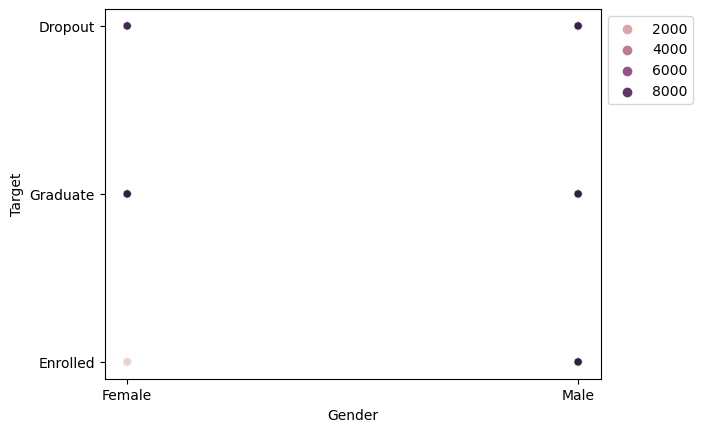

In [22]:
df["Gender"] = df["Gender"].map({0: "Male", 1: "Female"})

sns.scatterplot(x="Gender", y="Target", hue="Course", data=df)
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.show()

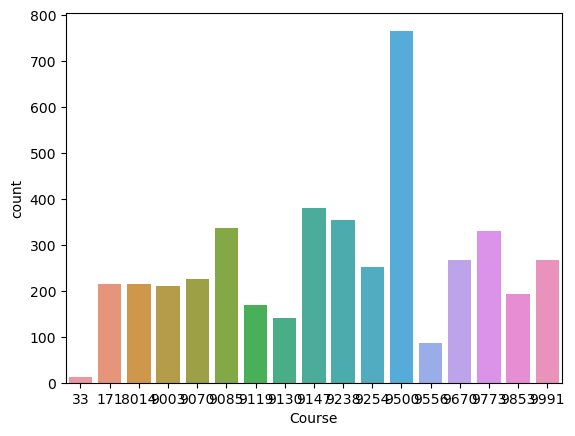

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Course', data=df, )
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv(r"C:\Users\Vennis\Downloads\BigDataAsgData.csv", sep=";")
sns.pairplot(df, hue='Course')
plt.show()

C:\Users\Vennis\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 9 (	) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Vennis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Vennis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Vennis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Vennis\anaconda3\Lib\sit